<figure>
  <img style="float: left;" src="./figures/unine.png" width="200"/>
</figure>

<figure>
  <img style="float: left;" src="./figures/fair_1.png" width="200"/>
</figure>

# Fairness

Machine learning (ML) usage is increasing every day. Companies and organisations build ML models with the purpose of minimising human effort or improving performance in various tasks. So today Machine learning arguably affects our lives.

Examples:
1. Recommendation system
2. Face recognition
3. Self-driving cars
4. Candidate selection e.x college admissions, CV screening
5. Loan admissions

There are a lot of examples that researchers demonstrate inadvertently discriminating against several population groups.    
The most know is [ProPublica's](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) research in COMPAS Dataset.

When machine learning models are being used to make decisions, they cannot be separated from the social and ethical context in which they are applied, and those developing and deploying these models must take care to do so in a manner that accounts for both performance and fairness. 

So in the last decade Fairness has become one of the most active research areas in ML.

# A2. Sources of Bias.

Bias may be introduced into a machine learning project at any step along the way, and it is important to carefully think through each potential source and how it may affect your results.


Source of bias:
- Data
    1. Historical injustice.
    2. Sample bias - Collection Bias.
    3. Limited features.
    4. Unbalanced dataset.
    5. Proxy Variables.
- Modelling
    1. Data preprocessing
    2. Model assumptions 
- Feedback loops.
    1. decisions based on biassed models lead to biassed dataset.  

<figure>
  <img style="float: left;" src="./figures/simple_pipeline.png" width="600"/>
</figure>


# A3. Load Dataset

https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

In [3]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binary target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)
    
    # Categorical dataset
    categorical_features = data.select_dtypes('category').columns
    data[categorical_features] = data.select_dtypes('category').apply(lambda x: x.cat.codes)
    return data

### load & clean dataset

In [4]:
# get and clean train dataset
TRAIN_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
train_data = train_data.dropna()
print("Train dataset shape:", train_data.shape)

# get and clean test dataset
TEST_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
test_data = test_data.dropna()
print("Test dataset shape:", test_data.shape)

Train dataset shape: (28938, 14)
Test dataset shape: (15175, 14)


In [5]:
train_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,6,9,13,4,0,1,4,1,2174.0,0,40,38,0
1,50,5,9,13,2,3,0,4,1,0.0,0,13,38,0
2,38,3,11,9,0,5,1,4,1,0.0,0,40,38,0
3,53,3,1,7,2,5,0,2,1,0.0,0,40,38,0
4,28,3,9,13,2,9,5,2,0,0.0,0,40,4,0


### Data analysis

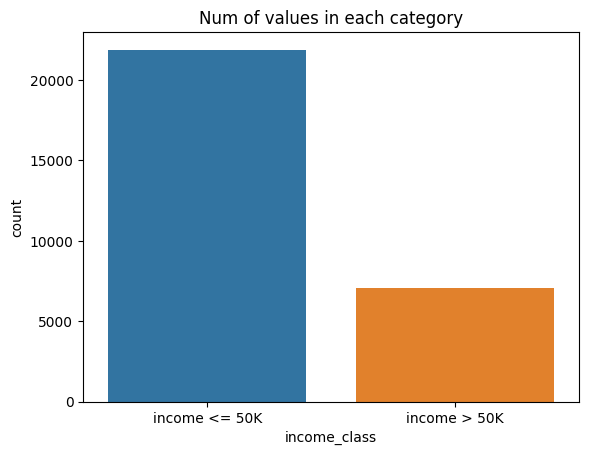

In [6]:
plt.figure()
fig = sns.countplot(x=train_data["income_class"])
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.title("Num of values in each category")
plt.show()
plt.close()

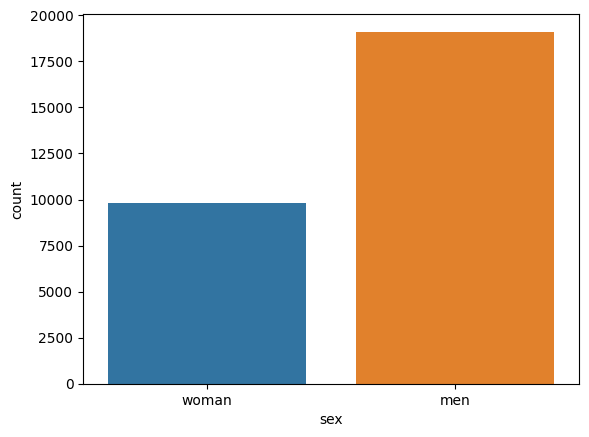

In [7]:
plt.figure()
fig = sns.countplot(x=train_data["sex"])
fig.set_xticklabels(['woman','men'])
# plt.title("gender")
plt.show()
plt.close()

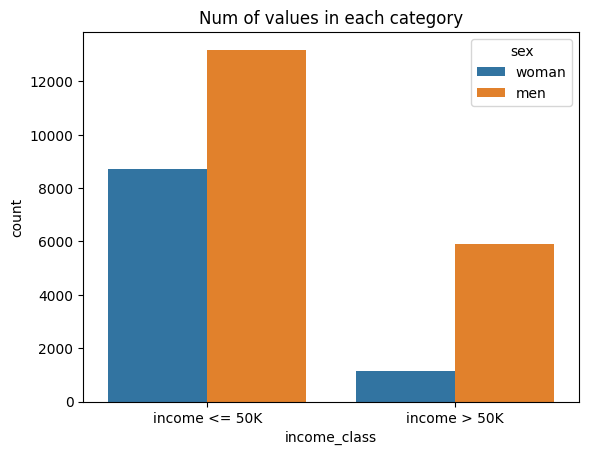

In [8]:
plt.figure()
fig = sns.countplot(data=train_data[["income_class","sex"]],
                    x="income_class",
                    hue="sex")
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.legend(title='sex', labels=['woman', 'men'])
plt.title("Num of values in each category")
plt.show()
plt.close()

The dataset is quite imbalance between a gender, so we expect our model to be unfair.
The source of the bias is coming from our societal bias.

# A4. Train a Model
let's train our model and analyse the results.

In [9]:
features = train_data.columns.difference([target_column])

# we define sex as our sensitive feature
sensitive_feature = ["sex"]

# all the rest are non sensitive feature
non_sensitive_features = list(set(features).difference(set(sensitive_feature)))

In [10]:
from sklearn.ensemble import RandomForestClassifier

model  = RandomForestClassifier(n_estimators=1000,
                                max_depth=10)

model.fit(X = train_data[sensitive_feature+non_sensitive_features],
          y = train_data[target_column])

RandomForestClassifier(max_depth=10, n_estimators=1000)

# Measure performance scores

Bellow are some of the most know mesurements scores


>1. Accuracy: $\frac{TP+TN}{TN + FP + FN + TP}$  
2. Recall: $\frac{TP}{ TP + FN }$ 
3. Precision: $\frac{TP}{ TP + FP }$  
4. F1-score: $2* \frac{ Recall * Precision}{Precision + Recall}$  

<div>
<img style="float: left;" src="./figures/conf_matrix.png" width="300"/>
</div>

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [12]:
conf_matrix = confusion_matrix(y_true = test_data[target_column],
                               y_pred = model.predict(test_data[sensitive_feature+non_sensitive_features]))
conf_matrix = pd.DataFrame(conf_matrix)

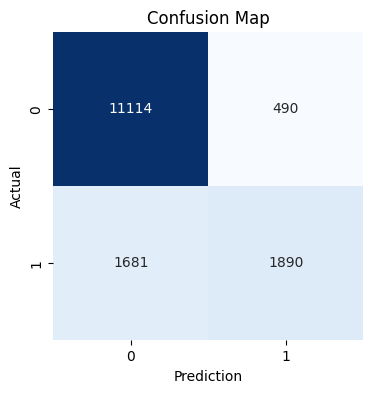

In [13]:
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=False, cmap="Blues")
plt.title("Confusion Map")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [14]:
TN, FP, FN, TP = conf_matrix.values.ravel()

acc_score = ( TN + TP ) / (TN + FP + FN + TP)
precision_score = TP / (TP + FP)
recall_score = TP / (TP + FN)
f1_score = 2*(precision_score*recall_score)/(precision_score+recall_score)

print("accuracy score:", acc_score)
print("precision score:", precision_score)
print("recall score:", recall_score)
print("f1 score:", recall_score)

accuracy score: 0.8569357495881383
precision score: 0.7941176470588235
recall score: 0.5292635116213946
f1 score: 0.5292635116213946


In [15]:
acc_score = accuracy_score(y_true = test_data[target_column],
                           y_pred = model.predict(test_data[sensitive_feature+non_sensitive_features]))
print("Accuracy_score:", acc_score)

Accuracy_score: 0.8569357495881383


# A5. Analysis of model fairness


Unfortunately there is not a single definition of fairness. There are many, often competing, ways to measure whether a given model is statistically “fair”, but it’s important to remember to start from the social and policy goals for equity and fairness and map those to the statistical properties we want in our models to help achieve those goals. Most of the definitions involve splitting the population into groups and compare metrics on those groups.

Different definition preserve different fairness aspects. So the desired fairness definition is depending on the application. In general, this requires consideration of the project’s goals, and a detailed discussion between the data scientists, decision makers, and those who will be affected by the application of the model.

Bellow we will define the most known fairness definitions.

1. **Demographic Parity** - equal positive outcome rates
2. **Equalized Opportunities** - equal true positive  rates
3. **Equalized Odds** -  equal true positive and false positive rate
4. **Predictive Parity** - equal Positive precision  
.  
.  
.  

In [16]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
predictions = pd.Series(predictions,index = test_data.index)
sensitive_atribute = test_data[sensitive_feature[0]]

In [17]:
woman_mask = sensitive_atribute == 0
conf_matrix_0 = confusion_matrix(y_true = test_data.loc[woman_mask,target_column],
                                 y_pred = predictions.loc[woman_mask])
conf_matrix_0 = pd.DataFrame(conf_matrix_0)

In [18]:
man_mask = sensitive_atribute == 1
conf_matrix_1 = confusion_matrix(y_true = test_data.loc[man_mask,target_column],
                                 y_pred = predictions.loc[man_mask])
conf_matrix_1 = pd.DataFrame(conf_matrix_1)

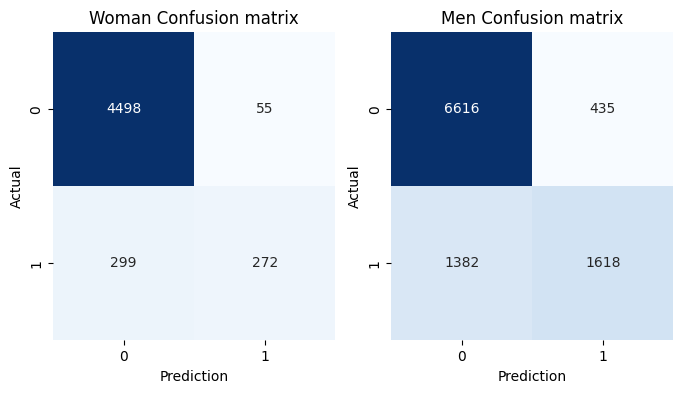

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (8,4))
sns.heatmap(conf_matrix_0, annot=True, fmt='g', cbar=False, cmap="Blues", ax=axes[0])
axes[0].set_title("Woman Confusion matrix")
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Prediction')

sns.heatmap(conf_matrix_1, annot=True, fmt='g', cbar=False, cmap="Blues", ax=axes[1])
axes[1].set_title("Men Confusion matrix")
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Prediction')
plt.show()
plt.close()

## F1.  Demographic Parity

**Demographic parity** , also referred to as **statistical parity** , **acceptance rate parity**  and **benchmarking**

Demographic Parity states that the positive outcome rates between sensitive group must be the same.

---------------
> **Definition Demographic Parity :** A classifier $C$ is said that satisfy **demographic parity** if $$ P_c(\hat{Y}= 1 | S = s ) =  P_c(\hat{Y} = 1), \quad  \forall s\in S $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we can also equivalent write:
$$ P_c(\hat{Y}= 1 | S = 0 ) =  P_c(\hat{Y}= 1 | S = 1 ) $$  
---------------

**How to measure Demographic parity?**

we can measure the Demographic parity using the Demographic parity difference metric.

> **Demographic parity difference :** we can measure the demographic parity using the next formula:
  $$  \text{Metric} =  max_s[P_c(\hat{Y}= 1 | S = s )] -  min_s[P_c(\hat{Y}= 1 | S = s )] $$  

In [20]:
def demographic_parity_difference(predictions, sensitive_attribute):
    """
    Implementation of demographic parity difference for different groups of sensitive attribute
    1. For each group calculate the propotion of accepted rate.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the proportion of accepted rate.
    unique_groups = np.sort(sensitive_attribute.unique())
    proportion_of_accepted_rate = []
    for group in unique_groups:
        pred_group = predictions[sensitive_attribute==group]
        accepted_rate = (pred_group==1).sum() / pred_group.shape[0]
        proportion_of_accepted_rate += [accepted_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_accepted_rate = max(proportion_of_accepted_rate)
    minimum_accepted_rate = min(proportion_of_accepted_rate)

    # 3. Calculate the different.
    difference = maximum_accepted_rate - minimum_accepted_rate
    
    return difference, proportion_of_accepted_rate

In [21]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]

In [22]:
demographic_metric, rates = demographic_parity_difference(predictions, sensitive_attribute)

In [23]:
print(f"Demographic parity difference is: {round(demographic_metric,5)}")

Demographic parity difference is: 0.14044


In [24]:
print(f"The rate of different groups are: {rates}")

The rate of different groups are: [0.06381733021077284, 0.20425828275793453]


---------------
**When to use demographic parity?** 
1. We are aware of **historical biases** that may have affected the quality of our data. E.x not presents of specific minority in a specific work.
2. We want to **change the state of our current world to improve it**. For example, we want to have equal admitions of different group in a specific project.


**Potential issues?** 
1. **Laziness**: We can satisfy demographic parity in we accept random people in group S=0 but qualified people in group  b unless we have the same proportion of positive outcome. We avoid lasyness because classfication is usually perfomred by optimizing an perfomance metric.
2. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F2. Equalized Opotunities

**Equalized Opportunities** , also referred to as **true positive parity**, **sensitivity**.

Equalized Opportunities states that each group has equal true positive rates.

---------------
> **Definition Equalized Opotunities :** A classifire $C$ is said that satisfy **equalized opotunities** if $$ P_c(\hat{Y} = 1 | S = s, Y = 1 ) =  P_c(\hat{Y} = 1 | Y = 1), \quad  \forall s\in S $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we can also equivalent write:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$  
---------------

**How to measure Equalized Opportunities?**

we can measure the equalized Opportunities using the equalized opportunities difference metric.

> **equalized opportunities difference :** we can measure the equalized opportunities using the next formula:
  $$  \text{Metric} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] $$  

**Hint**

> **True Positive Rate** : To calculate the $P_c(\hat{Y}= 1 | Y = 1 )$ you can do the following:
  $$  P_c(\hat{Y}= 1 | Y = 1 ) = \frac{P_c(\hat{Y}= 1, Y = 1 )}{P_c( Y = 1 )} = \frac{TP}{P} = \frac{TP}{TP+FN} $$ 

In [25]:
def equalized_opportunities_difference(predictions, actual, sensitive_attribute):
    """
    Implementation of equalized opportunities difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calculate the difference.
    """
    # 1. For each group calculate the TPR.
    unique_groups = np.sort(sensitive_attribute.unique())
    true_positive_rates = []
    for group in unique_groups:
        pred_group = predictions[sensitive_attribute==group]
        actual_group = actual[sensitive_attribute==group]
        conf_matrix = confusion_matrix(y_true = actual_group,
                                       y_pred = pred_group)
        TN, FP, FN, TP = conf_matrix.ravel()
        
        true_positive_rate = TP / (TP + FN)
        true_positive_rates += [true_positive_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_tpr = max(true_positive_rates)
    minimum_tpr = min(true_positive_rates)

    # 3. Calculate the different.
    difference = maximum_tpr - minimum_tpr
    
    return difference, true_positive_rates

In [26]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]
actual = test_data[target_column]

In [27]:
equalized_opportunities_metric, _ = equalized_opportunities_difference(predictions, actual, sensitive_attribute)

In [28]:
print(f"equalized opportunities difference is: {round(equalized_opportunities_metric,5)}")

equalized opportunities difference is: 0.06298


---------------
**When to use equalized opportunities?**
1. When is a strong emphasis on predicting the positive outcome correctly. e.x college admissions
2. When False Positives are not costly for the stakeholder. e.x spam detection

**Potential issues?** 
1. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F3. Equalized Odds

**Equalized Odds** , also referred to as

Equalized Odds states that the true positive rates (TPR) and false positive rates (FPR) between sensitive group must be the same.

- TPR = TP / total_positives  = TP / (TP+FN)
- FPR = FP / total_negatives = FP / (FP+TN)
---------------
> **Definition Equalized Odds :** A classifier $C$ is said that satisfy **equalized odds** if $$ P_c(\hat{Y} = 1 | S = s, Y = y ) =  P_c(\hat{Y} = 1 | Y = y), \quad  \forall s\in S, \forall y\in Y $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we want to satisfy both:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$ 
and 
$$ P_c(\hat{Y}= 1 | S = 0, Y = 0 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 0 ) $$  
---------------

**How to measure Equalized Opportunities?**

we can measure the equalized Opportunities using the equalized opportunities difference metric.

> **equalized opportunities difference :** we can measure the equalized opportunities using the next formula:
  $$   \text{Metric} = \text{true_positive_rate_difference} + \text{false_positive_rate_difference}  $$
where
  $$ \text{true_positive_rate_difference} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] $$ 
  $$ \text{false_positive_rate_difference} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 0 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 0 )] $$  

In [29]:
def equalized_odds_difference(predictions, actual, sensitive_attribute):
    """
    Implementation of equalized odds difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the TPR.
    unique_groups = np.sort(sensitive_attribute.unique())
    true_positive_rates = []
    false_positive_rates = []
    for group in unique_groups:
        pred_group = predictions[sensitive_attribute==group]
        actual_group = actual[sensitive_attribute==group]
        conf_matrix = confusion_matrix(y_true = actual_group,
                                       y_pred = pred_group)
        TN, FP, FN, TP = conf_matrix.ravel()
        
        true_positive_rate = TP / (TP + FN)
        false_positive_rate = FP / (FP + TN)
        
        true_positive_rates += [true_positive_rate]
        false_positive_rates += [false_positive_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_tpr = max(true_positive_rates)
    minimum_tpr = min(true_positive_rates)
    
    maximum_fpr = max(false_positive_rates)
    minimum_fpr = min(false_positive_rates)

    # 3. Calculate the different.
    difference_tpr = maximum_tpr - minimum_tpr
    difference_fpr = maximum_fpr - minimum_fpr
    difference = difference_tpr + difference_fpr
    
    return difference, (true_positive_rates,false_positive_rates)

In [30]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]
actual = test_data[target_column]

In [31]:
equalized_odds_metrics, _ = equalized_odds_difference(predictions, actual, sensitive_attribute)

In [32]:
print(f"equalized odds difference is: {round(equalized_odds_metrics,5)}")

equalized odds difference is: 0.11259


In [33]:
results = pd.DataFrame([acc_score,
                        precision_score,
                        recall_score,
                        f1_score,
                        demographic_metric,
                        equalized_opportunities_metric,
                        equalized_odds_metrics], 
                       index = ["accuracy",
                                "precision",
                                "recall",
                                "f1_score",
                                "demographic_metric",
                                "equalized_opportunities",
                                "equalized_odds"],
                       columns = ["model"])

----------------
**When to use equalized odds?** 
1. When is a strong emphasis on predicting the positive outcome correctly. e.x college admissions
2. When we strongly care about minimising costly False Positives

**Potential issues?** 
1. **Not optimality compatible**: A classifier that satisfy equalized odds is suboptimal, if the dataset demographic parity is not hold. Its more constrained than the equal opportunities, so the effect on perforce will be stronger
---------------

For your project you have explained why you choose the specific fairness criteria.

In [34]:
def compute_metric(y_pred, y_true, sensitive_feature):
    
    conf_matrix = confusion_matrix(y_true = y_true,
                                   y_pred = y_pred)
    conf_matrix = pd.DataFrame(conf_matrix)

    TN, FP, FN, TP = conf_matrix.values.ravel()

    acc_score = ( TN + TP ) / (TN + FP + FN + TP)
    precision_score = TP  / (TP + FP)
    recall_score = TP  / (TP + FN)
    f1_score = 2*(precision_score*recall_score)/(precision_score+recall_score)
    
    demographic_metric, _ = demographic_parity_difference(y_pred,
                                                          sensitive_feature)
    
    equalized_opportunities_metric, _ = equalized_opportunities_difference(y_pred,
                                                                           y_true,
                                                                          sensitive_feature)
    equalized_odds_metrics, _ = equalized_odds_difference(y_pred,
                                                          y_true,
                                                          sensitive_feature)
    
    return {
            "accuracy": acc_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1_score": f1_score,
            "demographic_metric": demographic_metric,
            "equalized_opportunities" : equalized_opportunities_metric,
            "equalized_odds": equalized_odds_metrics
            }

# B. Correct the unfair Clasifier

Numerous recent papers have proposed mechanisms to enhance fairness in machine learning
algorithms.

In summary there are 3 general methods to correct an unfair clasifier.

1. **Pre-Processing**: make changes in the data before training the model i.e remove correleted features
2. **In-Processing**: make changes in the model to correct fairness i.e add aditional loss terms to ensure fairness.
3. **Post-Processing**: make changes after the model's output i.e fix classification threshold.


For an overview of different methods and fairness critia we refer you to the following intresting survey https://arxiv.org/pdf/2001.09784.pdf.

<div>
<img style="float: left;" src="./figures/corect_unfairness.png" width="400"/>
</div>

### 1. Pre-Processing

Unfair models can be a result of bias in data. Pre-processing methods try to remove bias in data before it is used     to train models. The data is transformed and an algorithm is trained just as it would be on the original dataset.

Preprossing techiques can be seen as tranforming the data into a different representation to remove that bias.
Some of the most popular aproches are rebalacing techiques, remove sensitive features and their proxie variables, or tranform the data into a fair representation uning a machine learning algorithms.

pros:
1. We can use it for any downstram task. 
2. Pre-processing techique is not depended on the final classication model.
2. Most of the aproches dont need to have assecc in sensitive feature after training.

cons:
1. Has more influence on perfomance (degresing accuracy).
2. We can not fix all the different critia as some critia is pendenting on the classifier. For example to fix equalized odds we need to have assecc to the outcome of the classifier. 

### 2. In-Processing

In-Processing techiques considers fairness in the optimizion prossec of a classifier.  
In general In-Processing approach introduce contrains or regularization on the objective function when we train a classifier.  
Different tenquices where proposed eigther as a general framework or solution based on spesific classification algorithms.




pros:
1. Good performance on accuracy and fairness measures. 
2. Flexible between trade of of accuracy and fairness.
2. We dont need to have assecc in sensitive feature after training.

cons:
1. Different contrain may be difficult to apply.
2. Works with our spesific classifier. 
3. Need to modify classifier. We have to include contrains on retraining.

### 3. Post-Processing

These method post-process the output score of classifier to remove bias.
The most know tenquies are consider different classfication threshold for each group and try to satisfiy fairness critiria.

pros:
1. Can be applied after any classifiers.
2. Relatively good performance especially fairness measures.
2. No need to modify classifier.

cons:
1. Most of the time we require test-time access to the protected attribute
2. Not very flexible on the trade of between accuracy and fairness.

# B1. Pre-Processing

# B1.1 Unawareness
A very intuitive but **wrong solution** is to assume that ignoring the sensitive feature we can build a fair classifier.
This approach is wrong because other feature may be correlated with our sensitive features.

We will build a **Unawareness** classifier and the compare the results with our previous classifier.

In [35]:
from sklearn.ensemble import RandomForestClassifier

unaware_model  = RandomForestClassifier(n_estimators=1000,
                                        max_depth=10)

unaware_model.fit(X = train_data[non_sensitive_features],
                  y = train_data[target_column])

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [36]:
unaware_model.predict(test_data[non_sensitive_features])

array([0, 0, 0, ..., 1, 0, 1])

In [37]:
unaware_metrics = compute_metric(y_pred = unaware_model.predict(test_data[non_sensitive_features]),
                                 y_true = test_data[target_column],
                                 sensitive_feature = test_data["sex"])

In [38]:
unaware_results = pd.DataFrame(unaware_metrics,
                               index = ["unaware_model"]).T

In [39]:
unaware_results

,unaware_model
accuracy,0.857727
precision,0.796141
recall,0.531504
f1_score,0.637448
demographic_metric,0.139955
equalized_opportunities,0.061473
equalized_odds,0.110158


## Compare the results of 2 models

In [40]:
all_results = pd.concat([results, unaware_results],axis=1)
all_results

,model,unaware_model
accuracy,0.856936,0.857727
precision,0.794118,0.796141
recall,0.529264,0.531504
f1_score,0.635187,0.637448
demographic_metric,0.140441,0.139955
equalized_opportunities,0.062976,0.061473
equalized_odds,0.112589,0.110158


### Conclusion
Our conclusion is that we are not able to vanish unfairness by excluding sensitive features.  
The reason in that some other feature leak information about our sensitive attribute.

## B 1.2 Remove correlated features
From the above results we expect that our sensitive feature are correlate with non-sensitive feature in our analysis.
We will try to find and exclude also those feature in order to improve our fairness properties.

In [41]:
corr = {}
for f in non_sensitive_features:
    corr[f] =np.corrcoef(test_data[sensitive_feature[0]], test_data[f])[0,1]
corr = np.abs(pd.DataFrame(data=corr, index=["corr"]).T).sort_values(by="corr",ascending = False)

<Figure size 640x480 with 0 Axes>

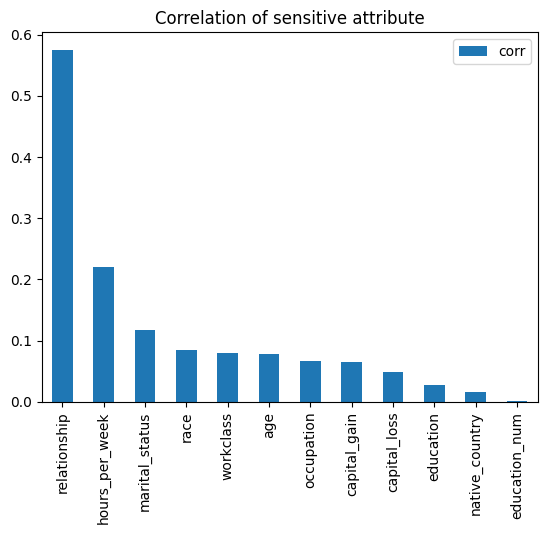

In [42]:
plt.figure()
corr.plot(kind="bar")
plt.title("Correlation of sensitive attribute")
plt.show()
plt.close()

#### build classifier excluding k most correlated feature

In [43]:
k=3
k_most_correlated = corr.iloc[0:k].index.values.tolist()

In [44]:
for i in range(len(k_most_correlated)):
    print(f"===========iteration{i+1}===========")
    training_features = list(set(non_sensitive_features).difference(set(k_most_correlated[0:i+1])))
    print("We exclude from training: ", k_most_correlated[0:i+1])
    
    # 1. train
    post_processing_model  = RandomForestClassifier(n_estimators=1000,
                                                    max_depth=10)

    post_processing_model.fit(X = train_data[training_features],
                              y = train_data[target_column])
    

    # 2. compute matrix
    post_processing_metrics = compute_metric(y_pred= post_processing_model.predict(test_data[training_features]),
                                             y_true= test_data[target_column],
                                             sensitive_feature = test_data["sex"])
    
    # 3. append result
    post_processing_results = pd.DataFrame(post_processing_metrics,
                                           index = [f"pre_prossesing_{i+1}"]).T
    
    all_results = pd.concat([all_results, post_processing_results],axis=1)

===========iteration1===========
We exclude from training:  ['relationship']
===========iteration2===========
We exclude from training:  ['relationship', 'hours_per_week']
===========iteration3===========
We exclude from training:  ['relationship', 'hours_per_week', 'marital_status']


In [45]:
all_results

,model,unaware_model,pre_prossesing_1,pre_prossesing_2,pre_prossesing_3
accuracy,0.856936,0.857727,0.856343,0.853904,0.834135
precision,0.794118,0.796141,0.800952,0.783027,0.843995
recall,0.529264,0.531504,0.518342,0.524503,0.362083
f1_score,0.635187,0.637448,0.629378,0.628207,0.506761
demographic_metric,0.140441,0.139955,0.146835,0.141046,0.068447
equalized_opportunities,0.062976,0.061473,0.102092,0.071902,0.026579
equalized_odds,0.112589,0.110158,0.154680,0.122375,0.027582


<AxesSubplot: >

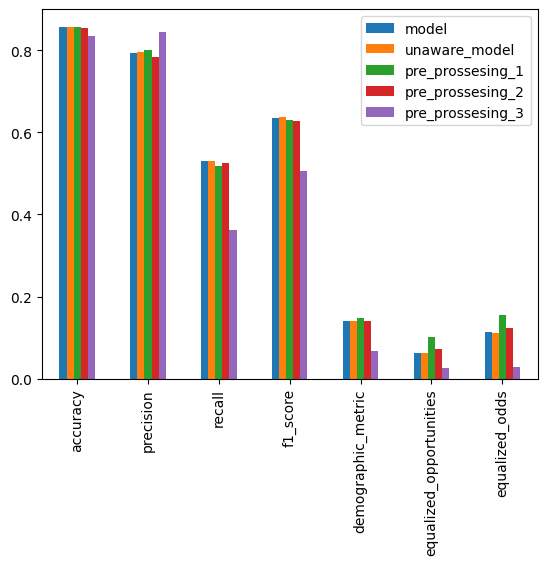

In [46]:
all_results.plot(kind="bar")

In [47]:
all_results

,model,unaware_model,pre_prossesing_1,pre_prossesing_2,pre_prossesing_3
accuracy,0.856936,0.857727,0.856343,0.853904,0.834135
precision,0.794118,0.796141,0.800952,0.783027,0.843995
recall,0.529264,0.531504,0.518342,0.524503,0.362083
f1_score,0.635187,0.637448,0.629378,0.628207,0.506761
demographic_metric,0.140441,0.139955,0.146835,0.141046,0.068447
equalized_opportunities,0.062976,0.061473,0.102092,0.071902,0.026579
equalized_odds,0.112589,0.110158,0.154680,0.122375,0.027582


# B2. Post-Processing



# Classification Threshold

A classifier is a function (or rule) that assign samples $X$ to label $\hat{Y}$  :
$${\hat {y}}=f(x)$$

In Probabilistic classifiers generalize this notion of classifiers. 


The **Probabilistic Classifier** estimates the probability of each class whit respect to the input sample $X$.
So the classifier estimates the conditional distributions : $\Pr(Y=y\vert X)$

And we can get the final class estimate:
$$\hat{y}=\operatorname {\arg \max }_{{y}}\Pr(Y=y\vert X)$$

In the case of binary classification we can also define a clasification threshold $t$ such that:

$$
 \hat{y}= 
\begin{cases}
    1, & \text{if} \Pr(Y=1\vert X) \geq t\\
    0, & \text{otherwise}
\end{cases}
$$

In the valina binary classification we use a classification theshold $t = 0.5$

In [48]:
predicted_probabilities = model.predict_proba(test_data[sensitive_feature+non_sensitive_features])
predicted_probabilities

array([[0.99763067, 0.00236933],
       [0.63100705, 0.36899295],
       [0.67169266, 0.32830734],
       ...,
       [0.34579928, 0.65420072],
       [0.74396392, 0.25603608],
       [0.33930613, 0.66069387]])

In [49]:
predicted_probabilities = predicted_probabilities[:, 1]
predicted_probabilities

array([0.00236933, 0.36899295, 0.32830734, ..., 0.65420072, 0.25603608,
       0.66069387])

In [50]:
def predict_with_threshold(probabilities, threshold):
    """
    preidct classification class based on threshold t.
    @propabilities: classification propabilities of positive class.
    @threshold: classification threshold.
    """
    # clalculate the prediction based on the propabilities and thresholds.
    # hint: use pandas masking to effintiantly calculate predictions.
    prediction = (probabilities >= threshold) * 1
    return prediction

In [51]:
predict_with_threshold(probabilities = predicted_probabilities,
                       threshold = 0.6)

array([0, 0, 0, ..., 1, 0, 1])

In [52]:
predict_with_threshold(probabilities = predicted_probabilities,
                       threshold = 0.3)

array([0, 1, 1, ..., 1, 0, 1])

### Caclulate differenet metrics for different thresholds

Bellow we will compute the different metrics using different classification threshold.   
As you can see from the bellow figure as we change threshold we have different **TP, FP, TN, FN** and thus we will have different metrics.

![thr](./figures/threshold.png)

In [53]:
thresholds = np.linspace(0,1,50)

metric_ts = []
for t in thresholds:
    prediction = predict_with_threshold(probabilities = predicted_probabilities,
                                        threshold = t)
    
    metrics = compute_metric(y_pred = prediction,
                             y_true = test_data[target_column],
                             sensitive_feature = test_data[sensitive_feature[0]])
    
    metric_ts += [metrics]

/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_39004/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)


In [54]:
ts_results = pd.DataFrame(metric_ts,index = thresholds)
ts_results.head()

,accuracy,precision,recall,f1_score,demographic_metric,equalized_opportunities,equalized_odds
0.000000,0.235321,0.235321,1.000000,0.380988,0.000000,0.000000,0.000000
0.020408,0.462339,0.304166,0.997760,0.466209,0.201058,0.000582,0.179564
0.040816,0.568962,0.351885,0.987959,0.518938,0.335428,0.027360,0.335896
0.061224,0.630247,0.387118,0.979558,0.554930,0.379837,0.048629,0.390901
0.081633,0.666820,0.411744,0.970036,0.578104,0.382971,0.070650,0.403487


<Figure size 1800x1800 with 0 Axes>

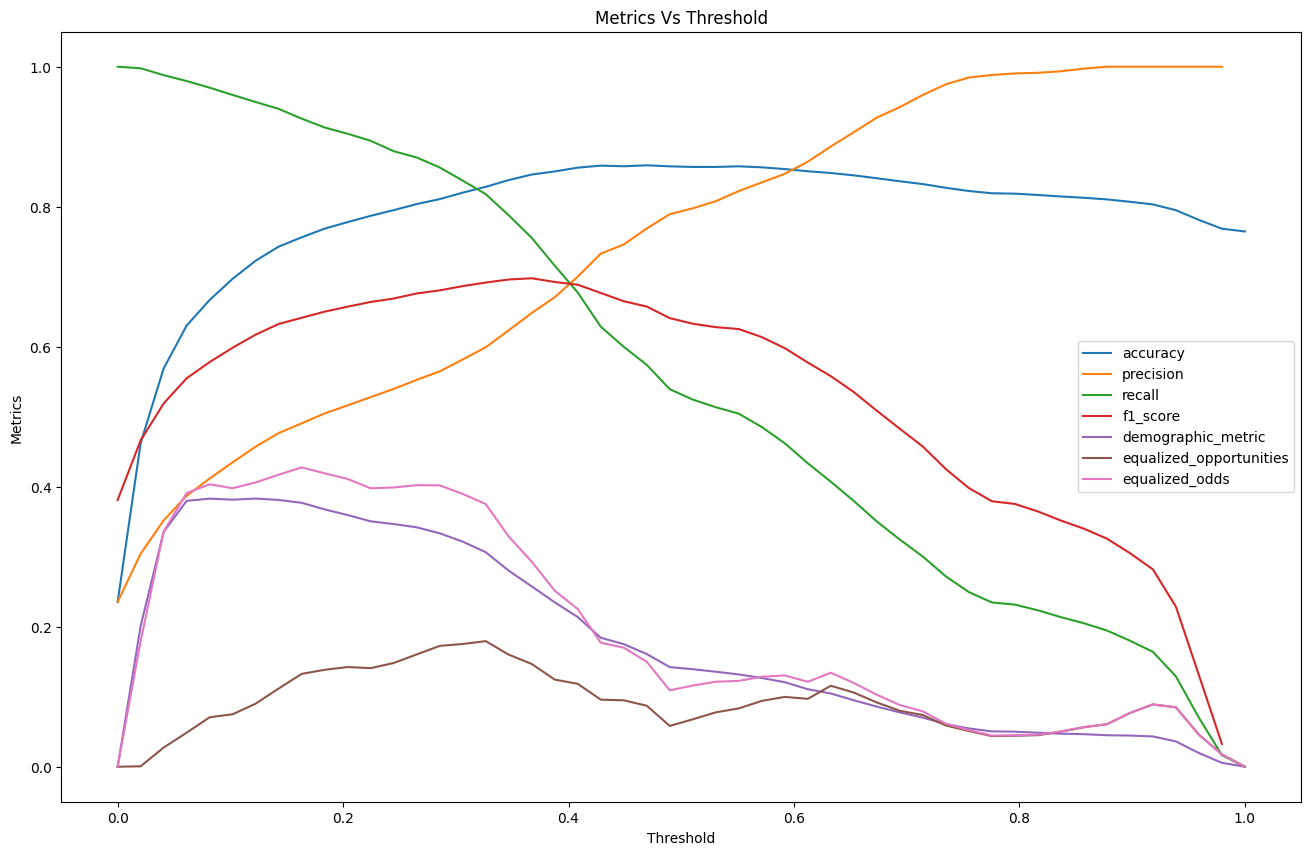

In [55]:
plt.figure(figsize=(18,18))
ts_results.plot(figsize=(16,10))
plt.title("Metrics Vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Metrics")
plt.show()
plt.close()

# ROC curve

Roc curve plot TPR vs FPR for different thresholds.  
Initially Roc curve was proposed to compare classifier i.e classifier with highter area under curve is a better clasifier.

<div>
<img style="float: left;" src="./figures/roc_curve.png" width="500"/>
</div>

In [56]:
def roc_curve(y_true, predicted_probabilities, thresholds):
    """
    Custom impementation of roc curve for binary clasification.
    """
    number_of_positives = (y_true == 1).sum()
    tpr, fpr, ppr = [], [], []
    for thr in thresholds:
        predictions = predict_with_threshold(probabilities = predicted_probabilities ,
                                             threshold =  thr)
        
        conf_matrix = confusion_matrix(y_true = y_true,
                                       y_pred = predictions)
    
        TN, FP, FN, TP = conf_matrix.ravel()    
        tpr += [TP / (TP + FN)]
        fpr += [FP / (FP + TN)]
        ppr += [(TP+ FP) / (TN + FP + FN+ TP)]
    
    return fpr, tpr, ppr, thresholds

In [57]:
predicted_probabilities = model.predict_proba(test_data[sensitive_feature+non_sensitive_features])[:, 1]
predicted_probabilities = pd.Series(predicted_probabilities,
                                    index=test_data.index)

In [58]:
thresholds = np.linspace(0.0, 1.0, 100)
fpr, tpr, ppr, thresholds = roc_curve(y_true= test_data[target_column], 
                                      predicted_probabilities= predicted_probabilities,
                                      thresholds= thresholds)

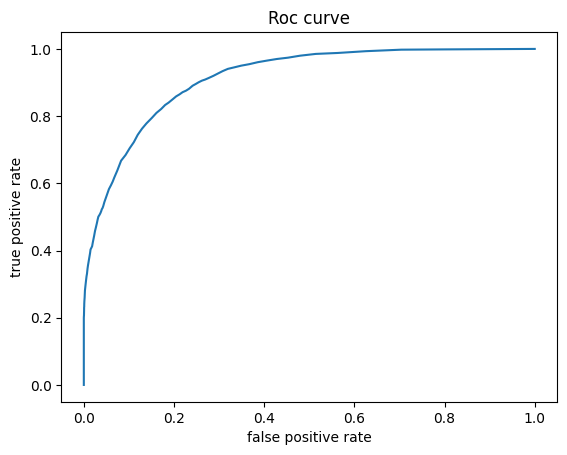

In [59]:
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("Roc curve")
plt.show()
plt.close()

# Calculate roc curve for different groups

In [60]:
mask_group_0 = test_data["sex"] == 0
mask_group_1 = np.logical_not(mask_group_0)

# group s=0
y_true_group_0 = test_data.loc[mask_group_0, target_column].values
scores_group_0 = predicted_probabilities.loc[mask_group_0].values
fpr_group_0, tpr_group_0, ppr_group_0, _ = roc_curve(y_true = y_true_group_0,
                                                     predicted_probabilities = scores_group_0,
                                                     thresholds = thresholds)

# group s=1
y_true_group_1 = test_data.loc[mask_group_1,target_column].values
scores_group_1 = predicted_probabilities.loc[mask_group_1].values
fpr_group_1, tpr_group_1, ppr_group_1, _ = roc_curve(y_true = y_true_group_1,
                                                     predicted_probabilities = scores_group_1,
                                                     thresholds = thresholds)

## 1. Correct demographic parity

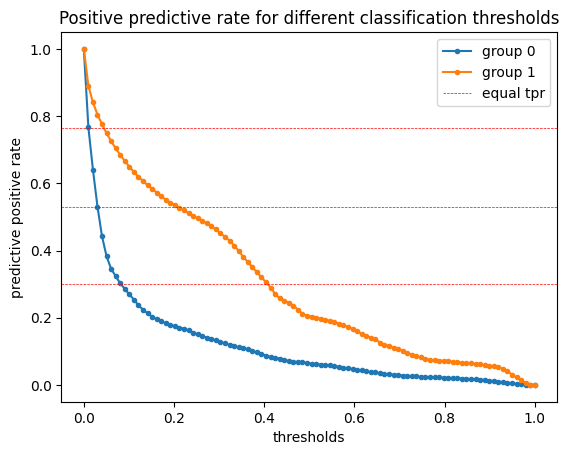

In [61]:
plt.figure()
plt.plot(thresholds, ppr_group_0, linestyle='-', marker='.', label = "group 0")
plt.plot(thresholds, ppr_group_1, linestyle='-', marker=".", label = "group 1")
plt.axhline(y = 0.765, color = 'r', linestyle = '--', linewidth = 0.5, label = "equal tpr")
plt.axhline(y = 0.53, color = 'r', linestyle = '--', linewidth = 0.5)
plt.axhline(y = 0.3, color = 'r', linestyle = '--', linewidth = 0.5)
plt.ylabel("predictive positive rate")
plt.xlabel("thresholds")
plt.title("Positive predictive rate for different classification thresholds")
plt.legend()
plt.show()
plt.close()

In [62]:
sensitivity = 0.01

accepted_thresholds = []
accepted_thresholds_index = []
for thr_index_0, ppr_0 in enumerate(ppr_group_0):
    abs_diff = np.abs(ppr_0 - ppr_group_1)
    arg_min = np.argmin(abs_diff)

    if abs_diff[arg_min] < sensitivity:
        accepted_thresholds_index.append((thr_index_0,arg_min))
        accepted_thresholds.append((thresholds[thr_index_0], thresholds[arg_min]))

In [63]:
metrics_thr_demographic_parity = []

for (thr0, thr1) in accepted_thresholds:
    thr_series_0 = mask_group_0 * thr0
    thr_series_1 = mask_group_1 * thr1
    thr = thr_series_0 + thr_series_1

    predictions = predict_with_threshold(probabilities = predicted_probabilities,
                                         threshold = thr)
    
    metrics = compute_metric(y_pred = predictions,
                             y_true = test_data[target_column],
                             sensitive_feature = test_data[sensitive_feature[0]])
    
    metrics_thr_demographic_parity += [metrics]
metrics_thr_demographic_parity = pd.DataFrame(metrics_thr_demographic_parity)

/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_39004/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_39004/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)


<AxesSubplot: >

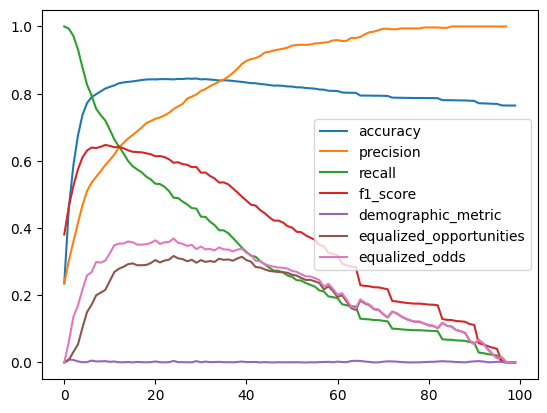

In [64]:
metrics_thr_demographic_parity.plot()

In [65]:
best_f1_score = metrics_thr_demographic_parity["f1_score"].idxmax()

In [66]:
best_model = metrics_thr_demographic_parity.loc[[best_f1_score]] 
best_model.rename(index={best_f1_score: 'post-prossesing best demographic parity'},inplace=True)

all_results = pd.concat([all_results, best_model.T],axis=1)

<AxesSubplot: >

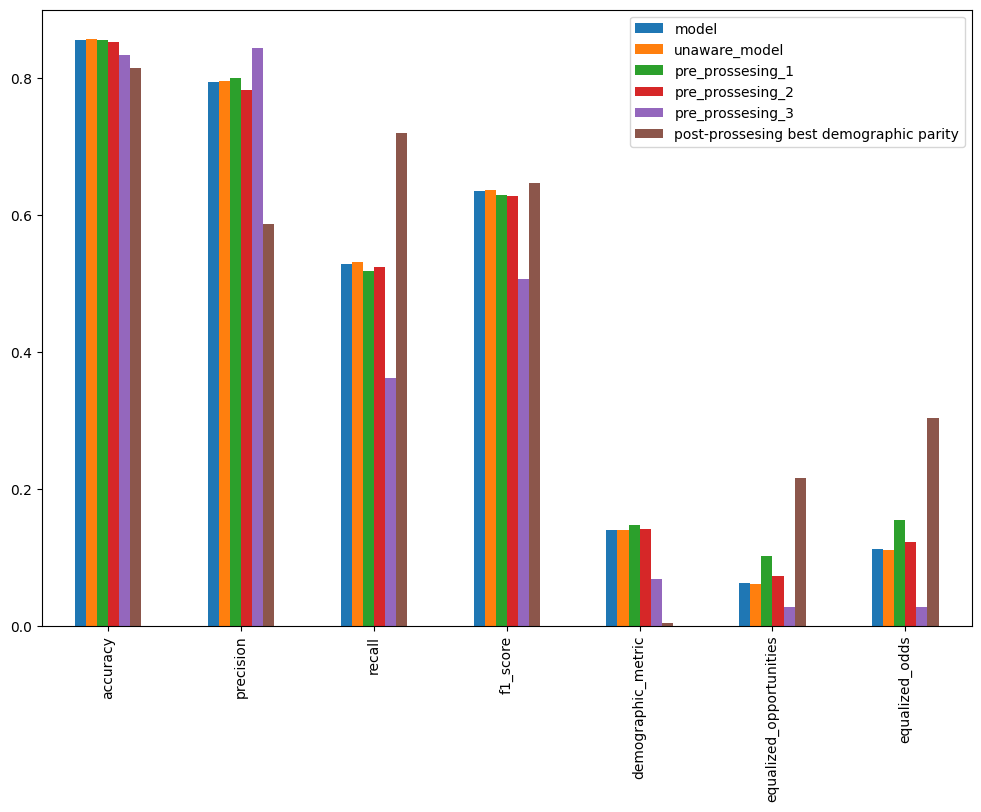

In [67]:
all_results.plot(kind="bar",figsize=(12,8))

## 2. Correct Equalized oportunities


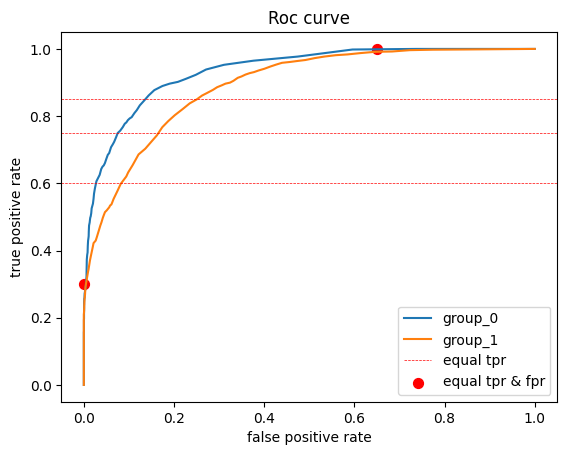

In [68]:
plt.figure()
plt.plot(fpr_group_0, tpr_group_0, linestyle='-', label = "group_0")
plt.plot(fpr_group_1, tpr_group_1, linestyle='-', label = "group_1")

plt.axhline(y = 0.85, color = 'r', linestyle = '--', linewidth = 0.5, label = "equal tpr")
plt.axhline(y = 0.75, color = 'r', linestyle = '--', linewidth = 0.5)
plt.axhline(y = 0.6, color = 'r', linestyle = '--', linewidth = 0.5)

plt.scatter([0.00,0.65], [0.3,0.999], color="r",s = 50, label = "equal tpr & fpr")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("Roc curve")
plt.legend()
plt.show()
plt.close()

In [69]:
sensitivity = 0.01

accepted_thresholds = []
accepted_thresholds_index = []
for thr_index_0, tpr_0 in enumerate(tpr_group_0):
    abs_diff = np.abs(tpr_0 - tpr_group_1)
    arg_min = np.argmin(abs_diff)

    if abs_diff[arg_min] < sensitivity:
        accepted_thresholds_index.append((thr_index_0,arg_min))
        accepted_thresholds.append((thresholds[thr_index_0], thresholds[arg_min]))

In [70]:
metrics_thr_eq_opportunities = []

for (thr0, thr1) in accepted_thresholds:
    thr_series_0 = mask_group_0 * thr0
    thr_series_1 = mask_group_1 * thr1
    thr = thr_series_0 + thr_series_1

    predictions = predict_with_threshold(probabilities = predicted_probabilities,
                                         threshold = thr)
    
    metrics = compute_metric(y_pred = predictions,
                             y_true = test_data[target_column],
                             sensitive_feature = test_data[sensitive_feature[0]])
    
    metrics_thr_eq_opportunities += [metrics]
metrics_thr_eq_opportunities = pd.DataFrame(metrics_thr_eq_opportunities)

/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_39004/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_39004/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)


In [71]:
best_f1_score = metrics_thr_eq_opportunities["f1_score"].idxmax()

In [72]:
best_model = metrics_thr_eq_opportunities.loc[[best_f1_score]] 
best_model.rename(index={best_f1_score: 'post-processing best equalize opportunities'},inplace=True)

all_results = pd.concat([all_results, best_model.T],axis=1)

<AxesSubplot: >

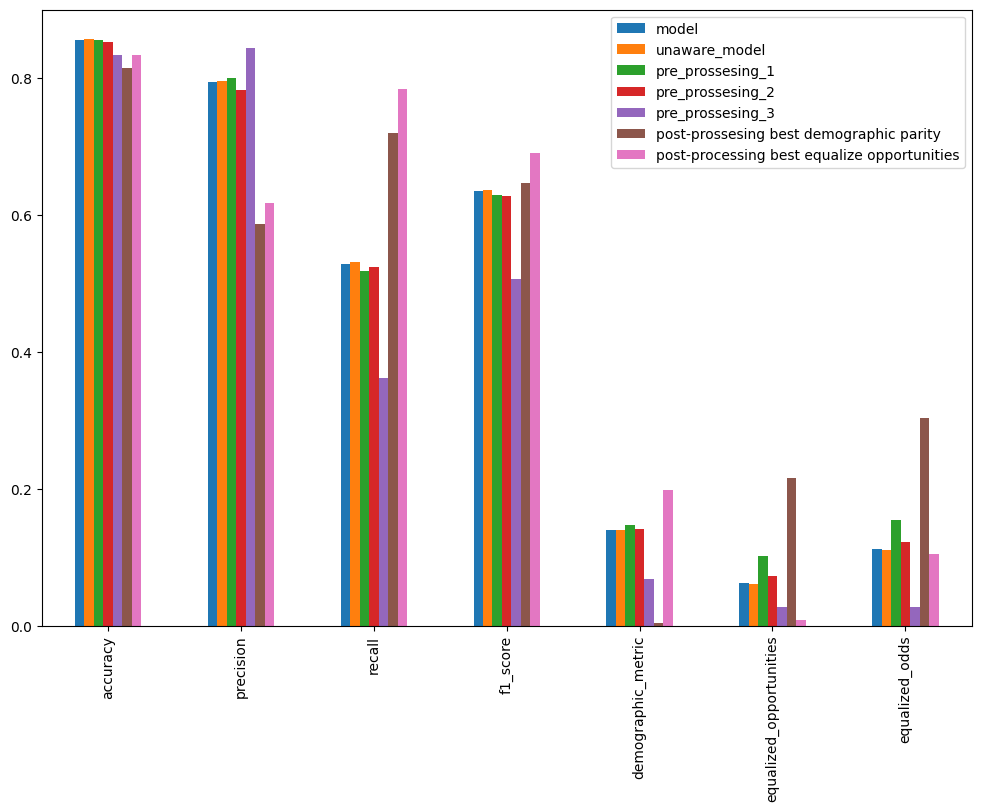

In [73]:
all_results.plot(kind="bar",figsize=(12,8))

## 2. Correct Equalized odds

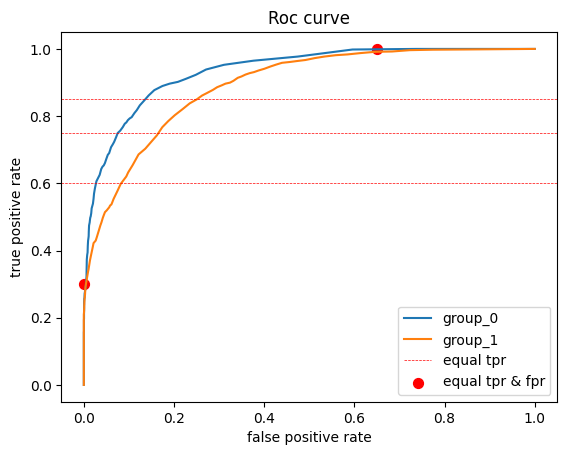

In [74]:
plt.figure()
plt.plot(fpr_group_0, tpr_group_0, linestyle='-', label = "group_0")
plt.plot(fpr_group_1, tpr_group_1, linestyle='-', label = "group_1")

plt.axhline(y = 0.85, color = 'r', linestyle = '--', linewidth = 0.5, label = "equal tpr")
plt.axhline(y = 0.75, color = 'r', linestyle = '--', linewidth = 0.5)
plt.axhline(y = 0.6, color = 'r', linestyle = '--', linewidth = 0.5)

plt.scatter([0.00,0.65], [0.3,0.999], color="r",s = 50, label = "equal tpr & fpr")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("Roc curve")
plt.legend()
plt.show()
plt.close()

In [75]:
sensitivity = 0.01

accepted_thresholds = []
accepted_thresholds_index = []

for thr_index_0, (tpr_0, fpr_0) in enumerate(zip(tpr_group_0, fpr_group_0)):    
    abs_diff_tpr = np.abs(tpr_0 - tpr_group_1)
    abs_diff_fpr = np.abs(fpr_0 - fpr_group_1)
    abs_diff = abs_diff_tpr + abs_diff_fpr
    arg_min = np.argmin(abs_diff)

    if abs_diff[arg_min] < sensitivity:
        accepted_thresholds_index.append((thr_index_0,arg_min))
        accepted_thresholds.append((thresholds[thr_index_0], thresholds[arg_min]))

In [76]:
metric_ts = []
for (thr0, thr1) in accepted_thresholds:
    thr_series_0 = mask_group_0 * thr0
    thr_series_1 = mask_group_1 * thr1

    thr = thr_series_0 + thr_series_1

    predictions = predict_with_threshold(probabilities = predicted_probabilities,
                                         threshold=thr)
    
    metrics = compute_metric(y_pred = predictions,
                             y_true = test_data[target_column],
                             sensitive_feature = test_data[sensitive_feature[0]])
    
    metric_ts += [metrics]

/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_39004/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_39004/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)


In [77]:
results_for_different_thr = pd.DataFrame(metric_ts)

In [78]:
best_f1_score = results_for_different_thr["f1_score"].idxmax()

In [79]:
best_model = results_for_different_thr.loc[[best_f1_score]] 
best_model.rename(index={best_f1_score: 'post-processing best equalized odds'},inplace=True)

all_results = pd.concat([all_results, best_model.T],axis=1)

<AxesSubplot: >

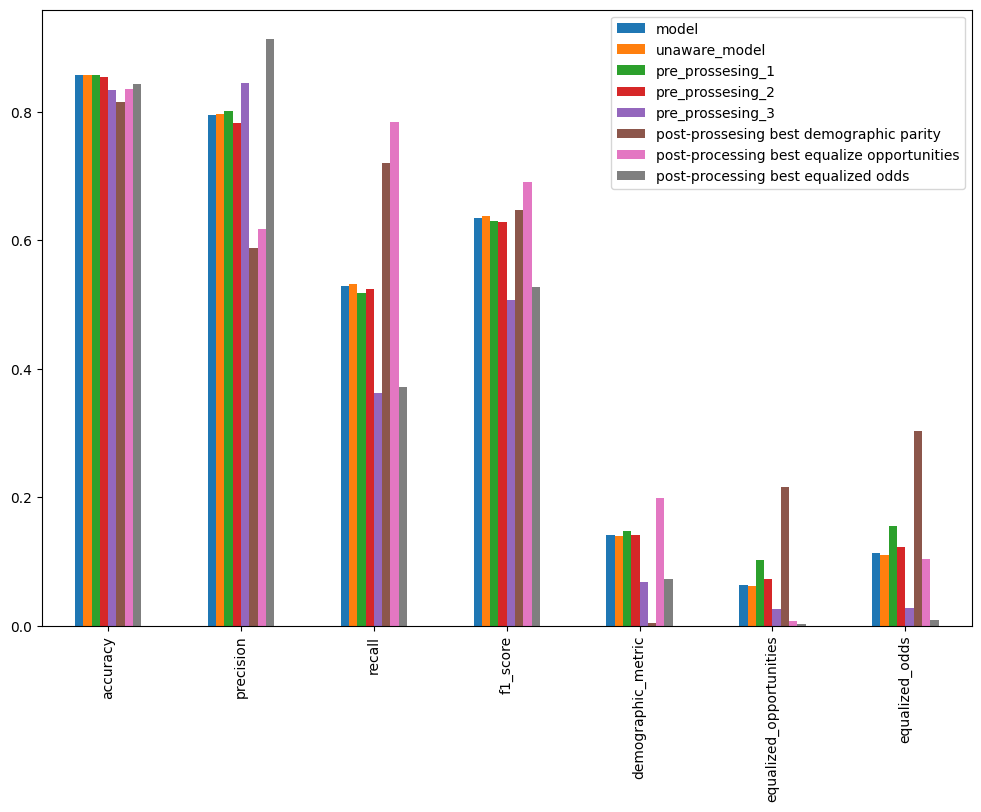

In [80]:
all_results.plot(kind="bar",figsize=(12,8))

# In-prossesing Method

# define tensorflow Model

In [81]:
import pandas

In [187]:
import tensorflow as tf

In [188]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [115]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
batch_size = 256
nn_model.compile(optimizer = optimizer,
                 loss = "binary_crossentropy",
                 metrics = "accuracy")

In [116]:
es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                      patience = 100)

history = nn_model.fit(train_data[non_sensitive_features + sensitive_feature],
                       train_data[target_column],
                       validation_split = 0.2,
                       batch_size=batch_size,
                       epochs=1000,
                       callbacks=es,
                       shuffle=True).history

Epoch 1/1000


/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


91/91 [==============================] - 0s 1ms/step - loss: 0.3239 - accuracy: 0.8494 - val_loss: 0.3384 - val_accuracy: 0.8454
Epoch 2/1000
91/91 [==============================] - 0s 599us/step - loss: 0.3239 - accuracy: 0.8504 - val_loss: 0.3371 - val_accuracy: 0.8457
Epoch 3/1000
91/91 [==============================] - 0s 703us/step - loss: 0.3231 - accuracy: 0.8499 - val_loss: 0.3378 - val_accuracy: 0.8454
Epoch 4/1000
91/91 [==============================] - 0s 590us/step - loss: 0.3233 - accuracy: 0.8500 - val_loss: 0.3393 - val_accuracy: 0.8426
Epoch 5/1000
91/91 [==============================] - 0s 577us/step - loss: 0.3225 - accuracy: 0.8512 - val_loss: 0.3386 - val_accuracy: 0.8464
Epoch 6/1000
91/91 [==============================] - 0s 562us/step - loss: 0.3232 - accuracy: 0.8507 - val_loss: 0.3370 - val_accuracy: 0.8476
Epoch 7/1000
91/91 [==============================] - 0s 542us/step - loss: 0.3253 - accuracy: 0.8503 - val_loss: 0.3387 - val_accuracy: 0.8424
Epoch 8

Epoch 58/1000
91/91 [==============================] - 0s 553us/step - loss: 0.3218 - accuracy: 0.8511 - val_loss: 0.3412 - val_accuracy: 0.8416
Epoch 59/1000
91/91 [==============================] - 0s 544us/step - loss: 0.3222 - accuracy: 0.8511 - val_loss: 0.3452 - val_accuracy: 0.8449
Epoch 60/1000
91/91 [==============================] - 0s 548us/step - loss: 0.3224 - accuracy: 0.8503 - val_loss: 0.3381 - val_accuracy: 0.8423
Epoch 61/1000
91/91 [==============================] - 0s 566us/step - loss: 0.3224 - accuracy: 0.8514 - val_loss: 0.3392 - val_accuracy: 0.8466
Epoch 62/1000
91/91 [==============================] - 0s 541us/step - loss: 0.3230 - accuracy: 0.8498 - val_loss: 0.3401 - val_accuracy: 0.8471
Epoch 63/1000
91/91 [==============================] - 0s 529us/step - loss: 0.3222 - accuracy: 0.8506 - val_loss: 0.3391 - val_accuracy: 0.8473
Epoch 64/1000
91/91 [==============================] - 0s 543us/step - loss: 0.3230 - accuracy: 0.8514 - val_loss: 0.3419 - val_ac

KeyboardInterrupt: 

In [ ]:
history.keys()

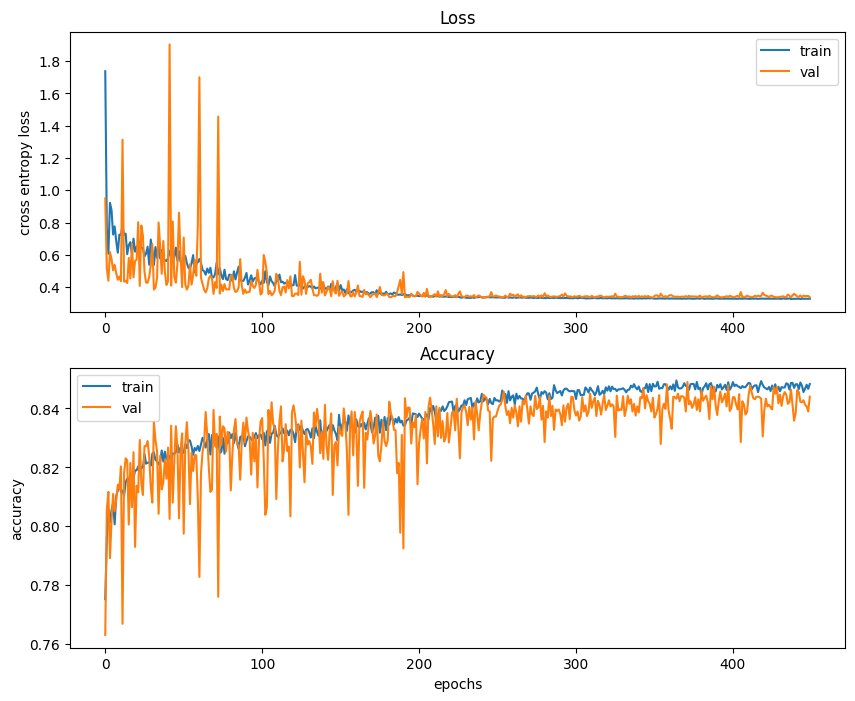

In [87]:
fig, ax = plt.subplots(ncols=1,nrows=2, figsize=(10,8))
ax[0].plot(history["loss"], label="train")
ax[0].plot(history["val_loss"], label="val")
ax[0].set_ylabel("cross entropy loss")
ax[0].legend()
ax[0].set_title("Loss")

ax[1].plot(history["accuracy"], label="train")
ax[1].plot(history["val_accuracy"], label="val")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].set_title("Accuracy")
plt.xlabel("epochs")
plt.show()
plt.close()

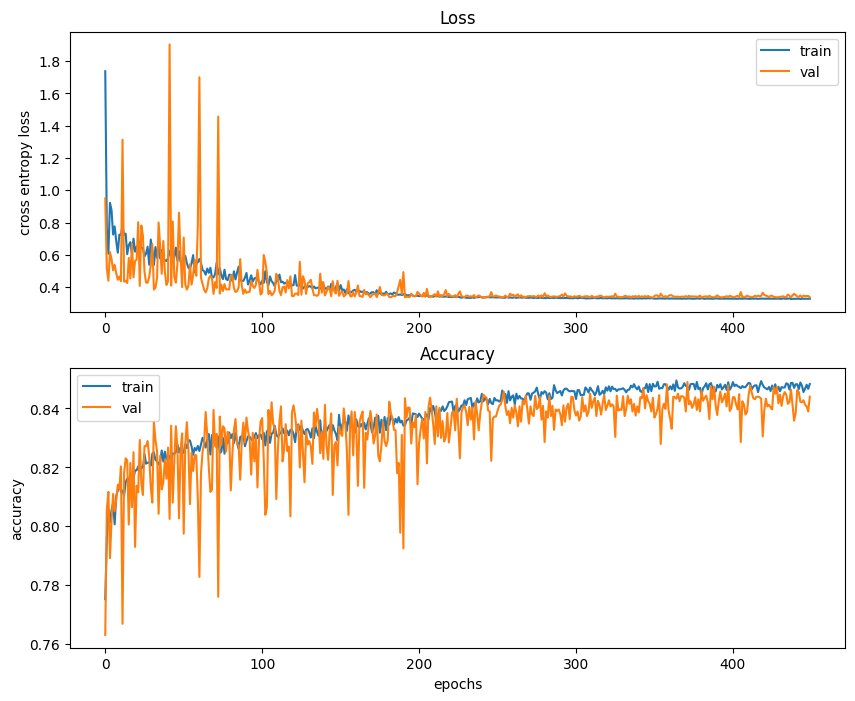

In [88]:
fig, ax = plt.subplots(ncols=1,nrows=2, figsize=(10,8))
ax[0].plot(history["loss"], label="train")
ax[0].plot(history["val_loss"], label="val")
ax[0].set_ylabel("cross entropy loss")
ax[0].legend()
ax[0].set_title("Loss")

ax[1].plot(history["accuracy"], label="train")
ax[1].plot(history["val_accuracy"], label="val")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].set_title("Accuracy")
plt.xlabel("epochs")
plt.show()
plt.close()

In [89]:
predicted_probabilities_nn = nn_model.predict(test_data[non_sensitive_features + sensitive_feature])

475/475 [==============================] - 0s 243us/step


In [90]:
predicted_probabilities_nn

array([[0.00088513],
       [0.37677452],
       [0.41067445],
       ...,
       [0.6514509 ],
       [0.57292396],
       [0.6589712 ]], dtype=float32)

In [93]:
predictions_nn = predict_with_threshold(probabilities = predicted_probabilities_nn,
                                        threshold = 0.5)
    
metrics_nn = compute_metric(y_pred = predictions_nn,
                            y_true = test_data[target_column],
                            sensitive_feature = test_data[sensitive_feature[0]])

metrics_nn = pd.DataFrame(metrics_nn,index=["Neural Network"])

In [94]:
all_results = pd.concat([all_results, metrics_nn.T],axis=1)

<AxesSubplot: >

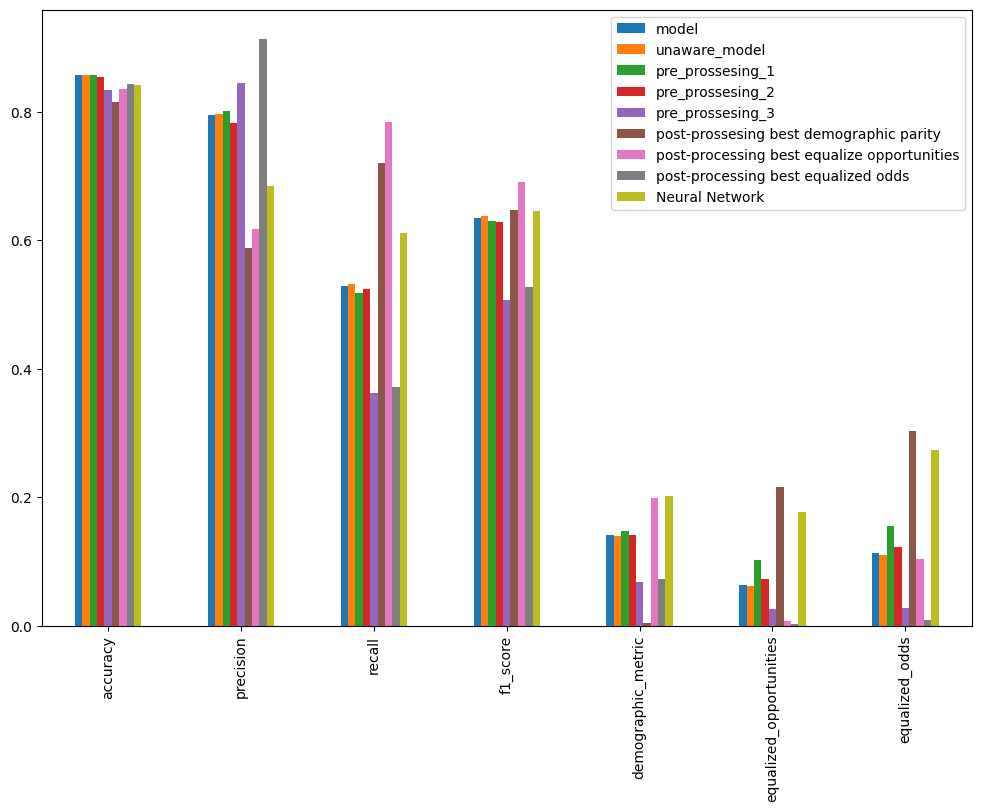

In [95]:
all_results.plot(kind="bar",figsize=(12,8))

# apply MMD loss

In [101]:
mask_group_0 = train_data[sensitive_feature[0]] == 0
mask_group_1 = np.logical_not(mask_group_0)

mask_target_0 = train_data[target_column] == 0
mask_target_1 = np.logical_not(mask_target_0)

In [100]:
sensitive_feature

['sex']

In [106]:
(mask_group_1 & mask_target_0).sum() + \
(mask_group_1 & mask_target_1).sum() + \
(mask_group_0 & mask_target_0).sum() + \
(mask_group_0 & mask_target_1).sum()

28938

In [164]:
x_train_g1 = train_data[non_sensitive_features+sensitive_feature].loc[mask_group_0]
x_train_g2 = train_data[non_sensitive_features+sensitive_feature].loc[mask_group_1]

y_train_g1 = train_data[[target_column]].loc[mask_group_0]
y_train_g2 = train_data[[target_column]].loc[mask_group_1]


In [166]:
x_tf_dataset_g1 = tf.data.Dataset.from_tensor_slices(train_g1)
y_tf_dataset_g1 = tf.data.Dataset.from_tensor_slices(y_train_g1)
tf_dataset_g1 = tf.data.Dataset.zip((x_tf_dataset_g1,y_tf_dataset_g1))
tf_dataset_g1 = tf_dataset_g1.shuffle(buffer_size=1000).batch(batch_size=batch_size//2,drop_remainder=True).repeat()

x_tf_dataset_g2 = tf.data.Dataset.from_tensor_slices(train_g2)
y_tf_dataset_g2 = tf.data.Dataset.from_tensor_slices(y_train_g2)
tf_dataset_g2 = tf.data.Dataset.zip((x_tf_dataset_g2,y_tf_dataset_g2))
tf_dataset_g2 = tf_dataset_g2.shuffle(buffer_size=1000).batch(batch_size=batch_size//2,drop_remainder=True).repeat()

final_tf_dataset = tf.data.Dataset.zip((tf_dataset_g1,tf_dataset_g2))

In [178]:
# loss_fn(tf.concat([y_g1, y_g2],axis=0),
#         tf.concat([y_hat_g1,y_hat_g2],axis=0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.31141153>

In [207]:
class CustromTrainer(tf.keras.Model):
    
    @tf.function
    def train_step(self, data):
        # unwrap dataset
        (x_g1, y_g1), (x_g2, y_g2) = data
        
        with tf.GradientTape() as tape:
            y_hat_g1 = self(x_g1)
            y_hat_g2 = self(x_g2)
            
            loss_bce_g0 = self.compiled_loss(y_g1,y_hat_g1)
            loss_bce_g1 = self.compiled_loss(y_g2,y_hat_g2)
            loss_bce = (loss_bce_g0 + loss_bce_g1)/2
        
        trainable_variable = self.trainable_variables
        grads = tape.gradient(loss_bce, trainable_variable)
        self.optimizer.apply_gradients(zip(grads, trainable_variable))
        self.compiled_metrics.update_state(tf.concat([y_g1,y_g2],axis=0),
                                           tf.concat([y_hat_g1,y_hat_g2],axis=0))
        return {m.name : m.result() for m in self.metrics}

In [208]:
len(non_sensitive_features + sensitive_feature)

13

In [240]:
input_layer = tf.keras.Input(shape=(13,))
x = tf.keras.layers.Dense(64, activation='relu')(input_layer)
propa = tf.keras.layers.Dense(1, activation='sigmoid')(x)

nn_model_2 = CustromTrainer(input_layer, propa)

In [241]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
nn_model_2.compile(optimizer = optimizer,
                 loss = "binary_crossentropy",
                 metrics = "accuracy")

In [242]:
es = tf.keras.callbacks.EarlyStopping(monitor = "loss",
                                      patience = 100)

history = nn_model_2.fit(final_tf_dataset,
                         steps_per_epoch= 91,
                         epochs=500,
#                          callbacks=es,
                         shuffle=True).history

Epoch 1/500
91/91 [==============================] - 0s 1ms/step - loss: 3.5979 - accuracy: 0.7689
Epoch 2/500
91/91 [==============================] - 0s 966us/step - loss: 0.5299 - accuracy: 0.8098
Epoch 3/500
91/91 [==============================] - 0s 973us/step - loss: 0.5046 - accuracy: 0.8151
Epoch 4/500
91/91 [==============================] - 0s 977us/step - loss: 0.5470 - accuracy: 0.8170
Epoch 5/500
91/91 [==============================] - 0s 950us/step - loss: 0.5402 - accuracy: 0.8190
Epoch 6/500
91/91 [==============================] - 0s 988us/step - loss: 0.4650 - accuracy: 0.8281
Epoch 7/500
91/91 [==============================] - 0s 1ms/step - loss: 0.4990 - accuracy: 0.8256
Epoch 8/500
91/91 [==============================] - 0s 982us/step - loss: 0.5423 - accuracy: 0.8268
Epoch 9/500
91/91 [==============================] - 0s 994us/step - loss: 0.4944 - accuracy: 0.8271
Epoch 10/500
91/91 [==============================] - 0s 956us/step - loss: 0.6264 - accuracy: 

91/91 [==============================] - 0s 982us/step - loss: 0.4453 - accuracy: 0.8461
Epoch 161/500
91/91 [==============================] - 0s 971us/step - loss: 0.3741 - accuracy: 0.8508
Epoch 162/500
91/91 [==============================] - 0s 947us/step - loss: 0.3728 - accuracy: 0.8493
Epoch 163/500
91/91 [==============================] - 0s 974us/step - loss: 0.4328 - accuracy: 0.8487
Epoch 164/500
91/91 [==============================] - 0s 969us/step - loss: 0.5099 - accuracy: 0.8465
Epoch 165/500
91/91 [==============================] - 0s 979us/step - loss: 0.3621 - accuracy: 0.8507
Epoch 166/500
91/91 [==============================] - 0s 962us/step - loss: 0.4089 - accuracy: 0.8461
Epoch 167/500
91/91 [==============================] - 0s 948us/step - loss: 0.4105 - accuracy: 0.8474
Epoch 168/500
91/91 [==============================] - 0s 991us/step - loss: 0.4399 - accuracy: 0.8514
Epoch 169/500
91/91 [==============================] - 0s 987us/step - loss: 0.4057 - a

91/91 [==============================] - 0s 970us/step - loss: 0.3727 - accuracy: 0.8509
Epoch 319/500
91/91 [==============================] - 0s 953us/step - loss: 0.4762 - accuracy: 0.8462
Epoch 320/500
91/91 [==============================] - 0s 956us/step - loss: 0.3700 - accuracy: 0.8525
Epoch 321/500
91/91 [==============================] - 0s 940us/step - loss: 0.4335 - accuracy: 0.8483
Epoch 322/500
91/91 [==============================] - 0s 954us/step - loss: 0.3892 - accuracy: 0.8504
Epoch 323/500
91/91 [==============================] - 0s 949us/step - loss: 0.4116 - accuracy: 0.8489
Epoch 324/500
91/91 [==============================] - 0s 928us/step - loss: 0.3781 - accuracy: 0.8514
Epoch 325/500
91/91 [==============================] - 0s 963us/step - loss: 0.3910 - accuracy: 0.8500
Epoch 326/500
91/91 [==============================] - 0s 944us/step - loss: 0.4328 - accuracy: 0.8484
Epoch 327/500
91/91 [==============================] - 0s 957us/step - loss: 0.3450 - a

91/91 [==============================] - 0s 962us/step - loss: 0.3879 - accuracy: 0.8535
Epoch 477/500
91/91 [==============================] - 0s 973us/step - loss: 0.3425 - accuracy: 0.8561
Epoch 478/500
91/91 [==============================] - 0s 978us/step - loss: 0.3417 - accuracy: 0.8583
Epoch 479/500
91/91 [==============================] - 0s 993us/step - loss: 0.3604 - accuracy: 0.8527
Epoch 480/500
91/91 [==============================] - 0s 991us/step - loss: 0.3619 - accuracy: 0.8548
Epoch 481/500
91/91 [==============================] - 0s 996us/step - loss: 0.4099 - accuracy: 0.8523
Epoch 482/500
91/91 [==============================] - 0s 993us/step - loss: 0.3774 - accuracy: 0.8527
Epoch 483/500
91/91 [==============================] - 0s 998us/step - loss: 0.3601 - accuracy: 0.8581
Epoch 484/500
91/91 [==============================] - 0s 999us/step - loss: 0.3870 - accuracy: 0.8537
Epoch 485/500
91/91 [==============================] - 0s 990us/step - loss: 0.3514 - a

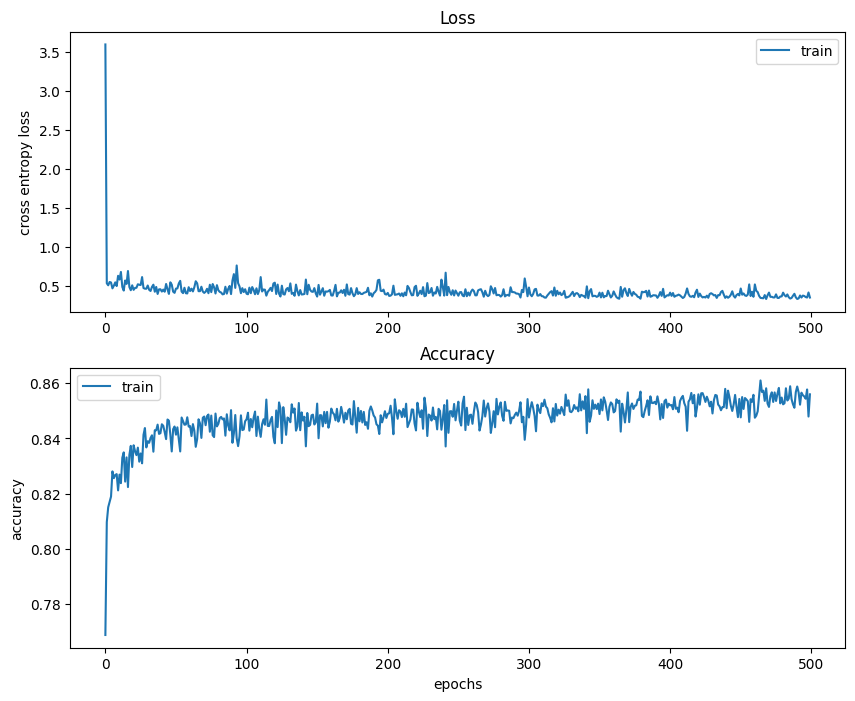

In [243]:
fig, ax = plt.subplots(ncols=1,nrows=2, figsize=(10,8))
ax[0].plot(history["loss"], label="train")
ax[0].set_ylabel("cross entropy loss")
ax[0].legend()
ax[0].set_title("Loss")

ax[1].plot(history["accuracy"], label="train")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].set_title("Accuracy")
plt.xlabel("epochs")
plt.show()
plt.close()

In [244]:
predicted_probabilities_nn2 = nn_model_2.predict(test_data[non_sensitive_features + sensitive_feature])

475/475 [==============================] - 0s 271us/step


In [245]:
predictions_nn2 = predict_with_threshold(probabilities = predicted_probabilities_nn2,
                                         threshold = 0.5)
    
metrics_nn2 = compute_metric(y_pred = predictions_nn2,
                            y_true = test_data[target_column],
                            sensitive_feature = test_data[sensitive_feature[0]])

metrics_nn2 = pd.DataFrame(metrics_nn2,index=["Custom Neural Network"])

In [246]:
metrics_nn2

,accuracy,precision,recall,f1_score,demographic_metric,equalized_opportunities,equalized_odds
Custom Neural Network,0.832751,0.70768,0.492859,0.58105,0.127514,0.025897,0.079121


In [247]:
all_results = pd.concat([all_results, metrics_nn2.T],axis=1)

<AxesSubplot: >

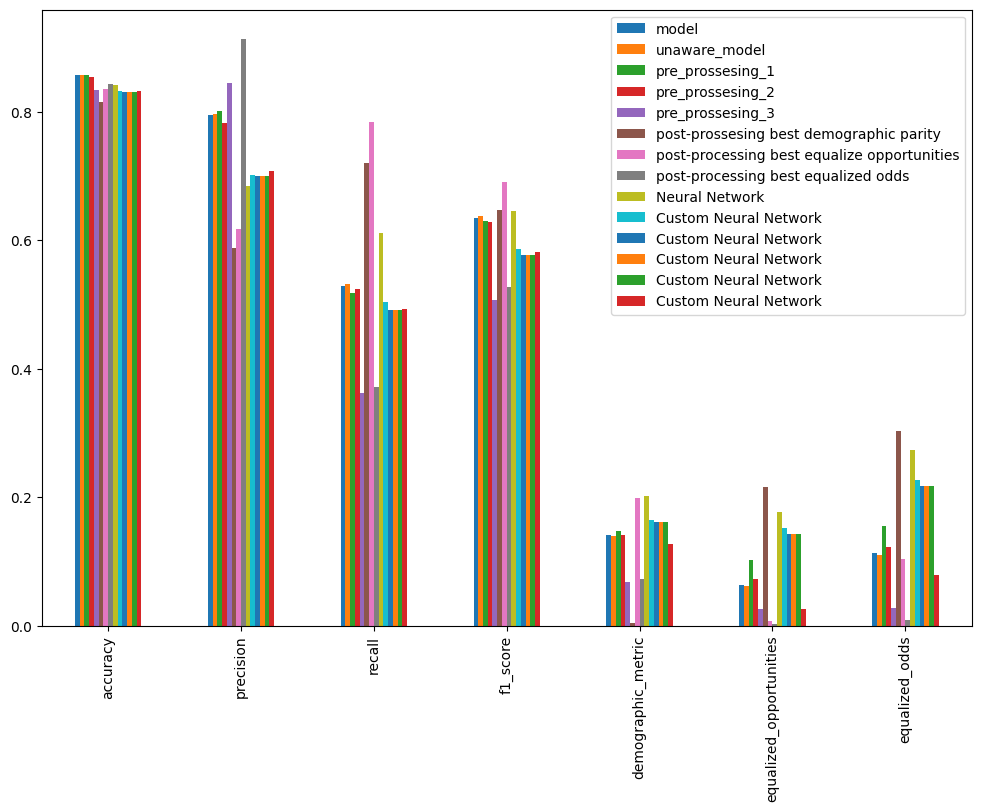

In [248]:
all_results.plot(kind="bar",figsize=(12,8))

In [185]:
epochs = 10
for epoch in range(epochs):
    print(epoch)
    
    for step, x in final_tf_dataset.enumerate():
        
        (x_g1, y_g1), (x_g2, y_g2) = x     
        
        with tf.GradientTape() as tape:
            y_hat_g1 = nn_model(x_g1)
            y_hat_g2 = nn_model(x_g2)
            
            loss_bce_g0 = loss_fn(y_g1,y_hat_g1)
            loss_bce_g1 = loss_fn(y_g2,y_hat_g1)
            loss_bce = (loss_bce_g0 + loss_bce_g1)/2
            
        grads = tape.gradient(loss_bce, nn_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, nn_model.trainable_weights))
        if step.numpy() > 100:
            break

0


2022-11-29 17:09:28.576199: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


1


2022-11-29 17:09:29.076301: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


2


2022-11-29 17:09:29.537823: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


3


2022-11-29 17:09:29.996349: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


4


2022-11-29 17:09:30.454080: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


5


2022-11-29 17:09:30.905736: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


6


2022-11-29 17:09:31.359240: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


7


2022-11-29 17:09:31.811654: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


8


2022-11-29 17:09:32.263501: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


9


2022-11-29 17:09:32.713849: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [126]:
step

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [128]:
(x_g1, y_g1), (x_g2, y_g2) = x 

In [ ]:
x_train_g1 = tf.data.Dataset.from_tensor_slices((train_g1, train_g2))
y_tf_dataset_train = tf.data.Dataset.from_tensor_slices((y_train_g1, y_train_g2))

In [ ]:
# train_data[non_sensitive_features + sensitive_feature].loc[mask_group_0 & mask_target_0]

# Thing you need to remember
1. Ml model are biased due to biases introduced by different sources. The most common are data dependent biases.
2. We have to select an appropriate criteria that fits our problem.
3. We can calculate the different criteria using confusion matrix of different groups
3. Removing sensitive features does not guarantee fairness as there are proxy variables. Most of the time does not influence our algorithm
4. We can remove biases using either pre-processing, in-processing or post-processing methods.
5. Different methods have different trade off between fairness and performance.

For an overview of different methods and fairness critia we refer you to the following survey https://arxiv.org/pdf/2001.09784.pdf.